In [1]:
import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
emotions = [' joyful_activation', ' amazement', ' power', ' tenderness', ' nostalgia', ' tension', ' calmness', ' sadness'] 

def process_target(fname):
    """
    Reads in the GEMs emotion-music dataset
    and returns a dicitonary mapping emotion
    to tracks. For each track, annotations
    summed across emotions and the emotion with
    the most annotations is selected as the label.
    
    Args:
        filename: name of GEMs data file
        
    Returns: (data frame, dictionary mapping
        emotions to dataframes)
    """
    target = pd.read_csv(fname)
    
    # find dominant emotion
    target = target.groupby(['track id', ' genre']).sum()
    target['dominant emotion'] = target[emotions].idxmax(axis=1)
    
    # convert to dictionary
    music_dict = {}
    for emotion in emotions:
        music_dict[emotion] = target[target['dominant emotion'] == emotion]
    
    return (target, music_dict)

target, music_dict = process_target('data/GEMS_data.csv')

In [3]:
video_params = ['rid', 'abpl', 'abar', 'abdo']
new_params = ['rid', 'pleasure', 'arousal', 'dominance']

def process_source(fname):
    """
    Reads in the EMMA emotion-video dataset
    as a DataFrame.
    
    Args:
        filename: name of EMMA data file
        
    Returns: data frame
    """
    source = pd.read_csv(fname, header=0)
    
    # clean input video dataset
    source = source[video_params]
    source.columns = new_params
    
    # HACKZ
    source[new_params[1:]] = source[new_params[1:]] > 0
    
    return source
    
source = process_source('data/input.csv')

In [4]:
def sample_songs(rid, num_samples=2):
    """
    Randomly samples a pair of songs from
    the GEMs dataset that correspond to the
    sentiment of the input song.
    
    Args:
        rid: id of a video from the EMMA 
        dataset
        
    Returns: DataFrame with 2 rows from GEMs DataFrame
    """
    russell_emotions = ['pleasure', 'arousal', 'dominance']
    russell_emotion_vector = source[source['rid'] == rid][russell_emotions].values.astype('int')[0]
    pleasure = russell_emotion_vector[0]
    arousal = russell_emotion_vector[1]
    dominance = russell_emotion_vector[2]
    
    if pleasure:
        if arousal:
            if dominance:
                return music_dict[' joy'].sample(num_samples)
            else:
                return music_dict[' amazement'].sample(num_samples)
        else:
            if dominance:
                return music_dict[' power'].sample(num_samples)
            else:
                music_dict[' tenderness'].sample(num_samples)
    else:
        if arousal:
            if dominance:
                return music_dict[' nostalgia'].sample(num_samples)
            else:
                return music_dict[' tension'].sample(num_samples)
        else:
            if dominance:
                return music_dict[' calmness'].sample(num_samples)
            else:
                music_dict[' sadness'].sample(num_samples2) 

In [5]:
test_rid = 4000
content, style = sample_songs(test_rid).index # index is (id, genre)

# processing to read correct file
content_id, content_genre = content
if content_id % 100 == 0:
    content_id = 100
else:
    content_id = content_id % 100
    
style_id, style_genre = style
if style_id % 100 == 0:
    style_id = 100
else:
    style_id = style_id % 100
source[source['rid'] == 4000]

,rid,pleasure,arousal,dominance
22,4000,False,True,False


In [6]:
CONTENT_FILENAME = "data/emotifymusic/%s/%d.mp3" % (content_genre, content_id%100)
STYLE_FILENAME = "data/emotifymusic/%s/%d.mp3" % (style_genre, style_id%100)

## Code from neural-style-audio-tf

In [17]:
test = True
if test:
    CONTENT_FILENAME = 'data/small_clips/rock_3.mp3'
    STYLE_FILENAME = 'data/small_clips/electronic_3.mp3'

In [19]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [20]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [21]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]

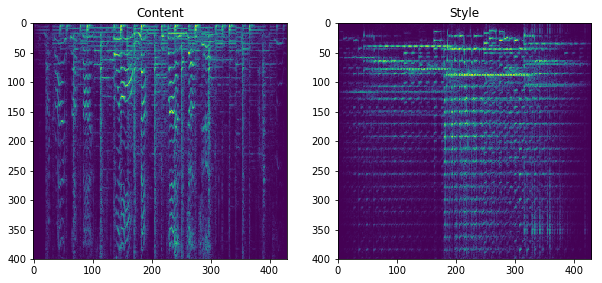

In [22]:
# visualize spectrograms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

In [ ]:
N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
    
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    
#     conv1 = tf.layers.conv2d(
#         inputs = x,
#         filters=11,
#         kernel_size=[N_CHANNELS, N_FILTERS],
#         padding="valid")
    
#     pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
#     conv2 = tf.layers.conv2d(
#       inputs=pool1,
#       filters=11,
#       kernel_size=[N_CHANNELS, N_FILTERS],
#       padding="same",
#       activation=tf.nn.relu)
  
#     pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES

In [ ]:
# optimize
from sys import stderr

ALPHA= 1e-2
learning_rate= 1e-3
iterations = 100

result = None
with tf.Graph().as_default():

    # Build graph with variable input
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")

    net = tf.nn.relu(conv)


    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print('Final loss:', loss.eval())
        result = x.eval()

Started optimization.


In [ ]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/out.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

In [ ]:
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()